## Aluno: Natanael da Silva Araújo

# Bibliotecas Utilizadas

In [46]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from ast import literal_eval
from sklearn.preprocessing import Imputer
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from wordcloud import WordCloud
import warnings; warnings.simplefilter('ignore')

# Problema
+ O problema proposto é um mecanismo para recomendação de filmes. Esse mecanismo deve ser capaz de dado uma entrada pelo usuário(nome de um filme) o sistema seja capaz de recomendar 5 novos filmes semelhantes ao que o usuário informou.  
  
# Funcionamento
+ A recomendação é baseada pelo conteudo do filme(diretor, titulo, ano de lançamento, atores, palavras, entre outros), dessa forma o usuário informa um filme e apartir dessa entrada será calculada a semelhança desse filme com o restante do dataset, a priori será formado uma lista com 50 filmes, dessa lista vai ser recomendado ao usuário 5 filmes mais semelhantes ao que ele informou.  

# Dados
+ Os dados disponibilizados contêm metadados para todos os 45.000 filmes listados no Conjunto de Dados Completo do MovieLens. O conjunto de dados consiste em filmes lançados em julho de 2017 ou antes. Os dados incluem elenco, equipe, palavras-chave, orçamento, receita, cartazes, datas de lançamento, idiomas, empresas de produção, países, contagem de votos TMDB e médias de votos.  
+ Este conjunto de dados também possui arquivos contendo 26 milhões de avaliações de 270.000 usuários para todos os 45.000 filmes. As classificações estão em uma escala de 1 a 5 e foram obtidas no site oficial do GroupLens.  

## Datasets Originais  
**movies_metadata.csv:** O principal arquivo de Metadados de Filmes. Contém informações sobre 45.000 filmes apresentados no conjunto de dados Full MovieLens. Os recursos incluem cartazes, panos de fundo, orçamento, receita, datas de lançamento, idiomas, países de produção e empresas.

**keywords.csv:** Contém as palavras-chave do enredo do filme para nossos filmes do MovieLens. Disponível na forma de um Objeto JSON com string.

**credits.csv:** Consiste em informações sobre o elenco e a equipe para todos os nossos filmes. Disponível na forma de um Objeto JSON com string.

**links.csv:** O arquivo que contém os IDs TMDB e IMDB de todos os filmes apresentados no conjunto de dados Full MovieLens.

**links_small.csv:** Contém os IDs TMDB e IMDB de um pequeno subconjunto de 9.000 filmes do Dataset Completo.

**ratings_small.csv:** O subconjunto de 100.000 avaliações de 700 usuários em 9.000 filmes.  

## Datasets Reduzidos  
**tmdb_5000_credits.csv:** Contém dados sobre o elenco e a equipe técnica do filme, possui dados de 5.000 mil filmes.  

**tmdb_5000_movies.csv:** Contém informações sobre os filmes, tais como, titulo, ano de lançamento, media de votos, entre outros.


  
  

# Tipo de Problema
+ Problema de recomendação

# Features Usadas
+ Como é um problema de aprendizado não supervisionado, logo não existe uma label(output). A seguir as features que vão ser usadas: 'index', 'genres', 'id', 'keywords', 'language', 'original_title', 'overview', 'popularity', 'spoken_languages', 'tagline', 'title', 'vote_average', 'num_voted_users', 'title_year', 'country', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'description'. Muitas não são do dataset original, foram derivadas.

# Metricas de Avaliação Usadas
+ Classificação Ponderada  
+ Distância Euclidiana  
+ Gaussian  
+ Cosine

## Pré-processamento dos Dados

**load_movies():** Função responsável por fazer o carregamento do arquivo que contem os dados sobre os filmes.

In [2]:
# Função responsável por carregar o arquivo csv com os dados no formato json
def load_movies(path):
    # Aqui é feito o carregamento do arquivo 'movies' csv
    data = pd.read_csv(path)
    # Aqui é aplicado uma função lambda na coluna que possui a data de lançamento
    data['release_date'] = pd.to_datetime(data['release_date']).apply(lambda x: x.date())
    # Aqui é gerado algumas colunas que seu formato no dataset é json
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    # Aqui é carrregado as colunas com formato json com a função json.loads
    for column in json_columns:
        data[column] = data[column].apply(json.loads)
    return data

**load_credits:** Essa função função é responsavel por fazer o carregamento do arquivo de creditos, onde contem informações importantes sobre os filmes, tais como: Atores, diretor e etc.

In [3]:
def load_credits(path):
    # Aqui é feito o carregamento do arquivo 'credits' csv
    data = pd.read_csv(path)
    # Aqui é gerado algumas colunas que seu formato no dataset é json
    json_columns = ['cast', 'crew']
    # Aqui é carrregado as colunas com formato json com a função json.loads
    for column in json_columns:
        data[column] = data[column].apply(json.loads)
    return data

+ Aqui é feito apenas a renomeação de algumas colunas do dataset, apenas para melhor visualização.

In [4]:
# Essas colunas são criadas com o objetivo de deixar os dados mais claros, alguns são renomeadas e outras permanecem iguais
COLUMNS_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'keywords',
    'vote_count': 'num_voted_users',
}

**safe_access():** Função já implementada pelo python, sua função é apenas verificar se uma chave existe em dicionario.

In [5]:
# Essa função verifica se uma chave está em um dicionario
# Essa função já está implementado e pode ser encontrada facilmente
def safe_access(container, index_values):
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

**get_director():** Essa função é responsavel por retornar o ou os diretores de um filme

In [6]:
# Essa função recebe a coluna crew que está em formato json, e devolve o nome do diretor com ajuda da função safe_access
def get_director(crew):
    directors = [x['name'] for x in crew if x['job'] == 'Director']
    return safe_access(directors, [0])

**get_words()** Aqui é feito apenas uma formatação nas palavras chaves de cada filme

In [7]:
# Essa função devolve as palavras chaves separadas por pipe(|), antes estavam em formato json 
def get_words(words):
    return '|'.join([x['name'] for x in words])

**convert():** Aqui é feito a união do dataset movies e com o dataset credicts.

In [8]:
# Essa função é responsavel por unir os dois datasets, dessa forma fica melhor na hora em que for realizar a recomendação.
def convert(dataset_movies, dataset_credits):
    # Aqui o dataset movies é copiado para a variavel movies_tmdb
    movies = dataset_movies.copy()
    # Aqui as colunas do dataset que está em movies_tmdb são renomeadas de acordo com as colunas definidas anteriormente.
    # o parametro inplace garante que a alteração seja feita na versão do dataset que está em memoria
    movies.rename(columns=COLUMNS_EQUIVALENCIES, inplace=True)
    # Aqui é adicionado a nova coluna 'title_year' onde está sendo gerada apartir do ano de lançamento do filme
    movies['title_year'] = pd.to_datetime(movies['release_date']).apply(lambda x: x.year)
    
    # Aqui assumi(baseado em uma leitura que fiz) que o primeiro pais que aparece na coluna é o pais de produção
    # É criada a nova conluna country e preenchida com o pais de produção
    movies['country'] = movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    # Aqui só é pegado a primeira linguagem que aparece na coluna
    movies['language'] = movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    # Aqui é identificado o nome do diretor
    movies['director_name'] = dataset_credits['crew'].apply(get_director)
    movies['actor_1_name'] = dataset_credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    movies['actor_2_name'] = dataset_credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    movies['actor_3_name'] = dataset_credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    movies['genres'] = movies['genres'].apply(get_words)
    movies['keywords'] = movies['keywords'].apply(get_words)
    return movies

+ Aqui é carregado os datasets

In [9]:
# Carregamento dos dados
dataset_credits = load_credits("tmdb-5000-movie-dataset/tmdb_5000_credits.csv")
dataset_movies = load_movies("tmdb-5000-movie-dataset/tmdb_5000_movies.csv")
dados = convert(dataset_movies, dataset_credits)

Na proxima celula é feita a remoção de colunas do dataset que são de baixa relevancia para a resolução do problema. Essas colunas são removidas, pois podem prejudicar o resultado final.

In [10]:
# Aqui é feito a remoção de colunas julgadas de pouca relevância
dados = dados.drop(['budget', 'homepage', 'gross', 'status', 'duration', 'production_countries', 
                    'release_date', 'production_companies'], axis=1);

In [11]:
dados['title_year'] = dados['title_year'].values.astype(np.int64)

#### O dataset final

In [12]:
dados.head(3)

,genres,id,keywords,language,original_title,overview,popularity,spoken_languages,tagline,title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,Action|Adventure|Fantasy|Science Fiction,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Enter the World of Pandora.,Avatar,7.2,11800,2009,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,Adventure|Fantasy|Action,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'iso_639_1': 'en', 'name': 'English'}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,Action|Adventure|Crime,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",A Plan No One Escapes,Spectre,6.3,4466,2015,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes


### A seguir um gráfico da matriz de correlação de todo o dataset

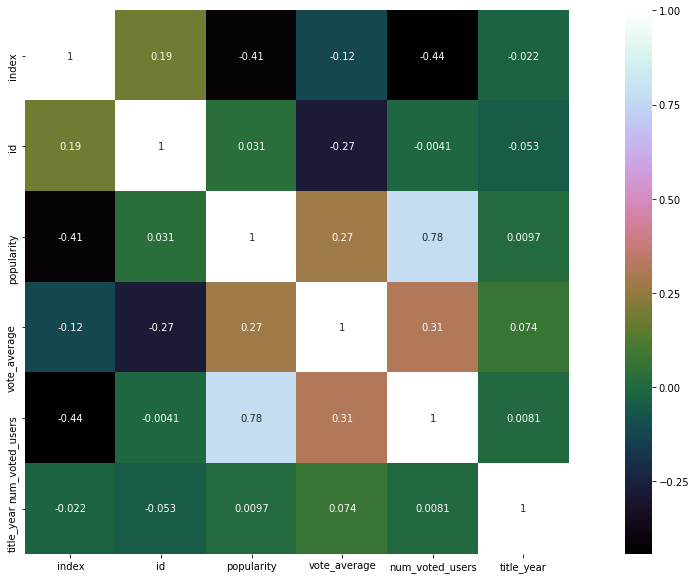

In [41]:
corr_mat= dados.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix');

### A seguir é mostrado um word cloud com as palavras chaves mais freguentes.

**set_keywords:** Cria um conjunto com as palavras chaves

In [43]:
set_keywords = set()
for list_keywords in dados['keywords'].str.split('|').values:
    if isinstance(list_keywords, float): continue 
    set_keywords = set_keywords.union(list_keywords)

set_keywords.remove('')

**count_word:** Retorna um dicionario com a palavra e sua freguencia.

In [44]:
def count_word(df, ref_col, list_):
    keyword_count = dict()
    for name in list_: keyword_count[name] = 0
    for list_keywords in df[ref_col].str.split('|'):        
        if type(list_keywords) == float and pd.isnull(list_keywords): continue        
        for s in [s for s in list_keywords if s in list_]: 
            if pd.notnull(s): keyword_count[s] += 1

    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count

In [50]:
keyword_occurences, dum = count_word(dados, 'keywords', set_keywords)

**random_color_func:** Apenas randomiza as cores no world cloud

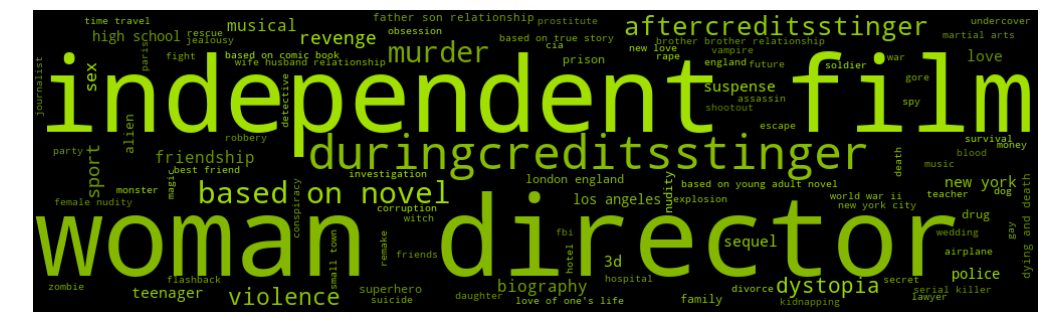

In [51]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_occurences[0:100]
for name in trunc_occurences:
    words[name[0]] = name[1]
tone = 55.0

wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                      max_words=1628, relative_scaling=1,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off');

### A seguir é mostrado um word cloud com os generos mais freguentes.

In [52]:
genre_labels = set()
for s in dados['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [59]:
keyword_occurences, dum = count_word(dados, 'genres', genre_labels)

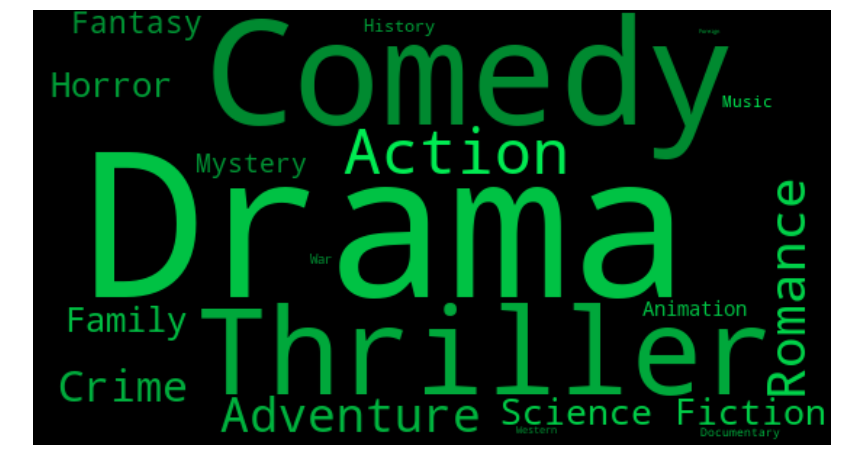

In [60]:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for name in trunc_occurences:
    words[name[0]] = name[1]
tone = 100 
f, ax = plt.subplots(1, figsize=(18, 8))
wordcloud = WordCloud(width=550, height=300, background_color='black', 
                      max_words=1628, relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Top 10 dos filmes mais bem avaliados.
Aqui é utilizada a formula de classificação ponderada do IMDB's, para construir essa classificação. A formula é representada assim:  


\begin{equation}
     \textbf{Classificação Ponderada} = (\frac{v}{v + m} * R) + (\frac{m}{v + m} * C)
\end{equation}  

* V é numero de votos para o filme
* M é o mínimo de votos necessários para o filme ser listado
* R é a classificação média do filme
* C é a média de votos em todo o dataset


A seguir é calculado o parametro C, no qual é a media dos votos de todos os filmes. E tambem é calculado a quantidade de votos que cada filme obteve.

In [13]:
vote_counts = dados[dados['num_voted_users'].notnull()]['num_voted_users'].astype('int')
vote_averages = dados[dados['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
print("Media de votos de todos os filmes: ", C, '\n')

Media de votos de todos os filmes:  5.6529252550489275 



**Nesse proximo passo é definido um valor minimo de votos para o filme ser classificado (M). Foi definido como parametro de seleção um percentil de 95%, ou seja, para um filme ser classificado ele deve ter mais votos do que 95% da lista toda.**

In [14]:
minimo = vote_counts.quantile(0.95)
print("Valor minimo de votos: ", minimo, '\n')

Valor minimo de votos:  3040.8999999999996 



**Portanto, para se qualificar para ser mostrado no top10, um filme precisa ter pelo menos 3040 votos no TMDB. Também vemos que a classificação média de um filme no TMDB é de 5.652 em uma escala de 10. Os 241 filmes se qualificam para estar em nosso top10 (A seguir é calculado a quantidade de filmes que se qualificam).**

In [15]:
qualified = dados[(dados['num_voted_users'] >= minimo) & (dados['num_voted_users'].notnull()) & (dados['vote_average'].notnull())][['title', 'title_year', 'num_voted_users', 'vote_average', 'popularity', 'genres']]
qualified['num_voted_users'] = qualified['num_voted_users'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(241, 6)

**A seguir é definida a formula para o calculo da classificação.**

In [16]:
def weighted_rating(x):
    v = x['num_voted_users']
    R = x['vote_average']
    return (v / (v + minimo) * R) + (minimo / (minimo + v) * C)

**Agora vamos criar uma nova coluna onde vai estar o valor da clssificação ponderada para os 241 filmes qualificados.**

In [17]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('weighted_rating', ascending=False).head(241)

### Agora podemos ver nosso top10

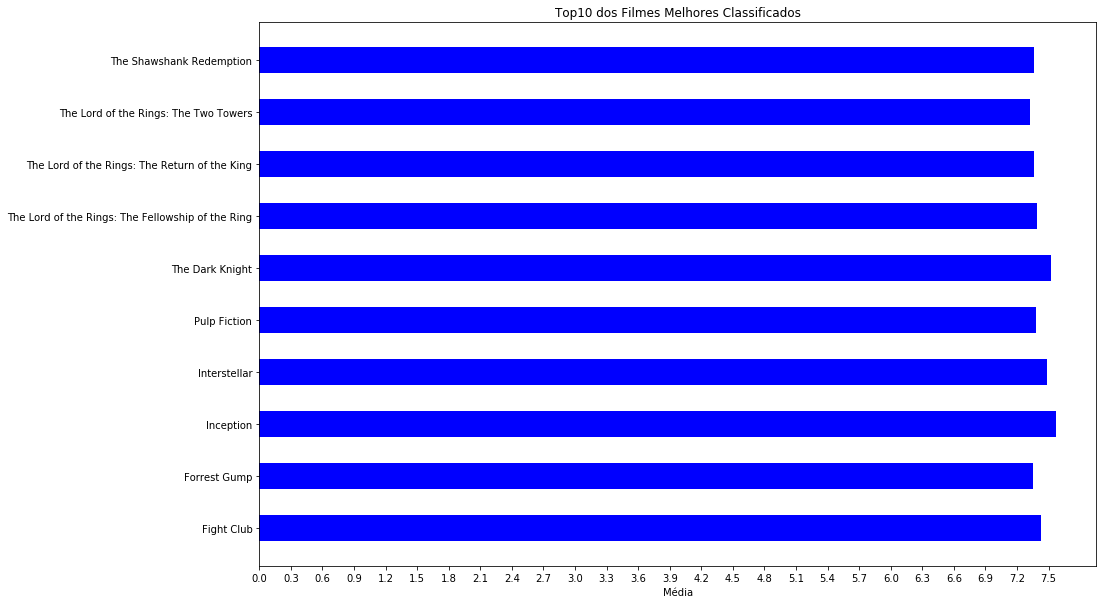

In [101]:
y = qualified['weighted_rating'].head(10)
x = qualified['title'].head(10)

fig, ax = plt.subplots(figsize=(15, 10))    
width = 0.5

ax.barh(x, y, width, color="blue")
ax.set_xticks(np.arange(0, max(y), 0.3))

plt.title('Top10 dos Filmes Melhores Classificados')
plt.xlabel('Média')
plt.show()

# Sistema de Recomendação

### Funções básicas:
    1. Determinar N filmes com um conteúdo semelhante ao fornecido pelo usuário.
    2. Selecionar os 5 filmes mais populares entre esses N filmes.

**Calculando a Similaridade**  
    A primeira coisa a fazer é definir um criterio que compute o quão dois filmes são próximos. Para isso, é necessário extrair algumas informações do filme selecionado pelo usuário, tais como: nome do diretor, os nomes dos atores e algumas palavras-chaves. Com isso construo uma matriz onde cada linha corresponde a um filme do dataset e onde as colunas correspondem às informações anteriores (diretor + atores + palavras-chave) mais os k gêneros.  
    
Nesta matriz, os coeficientes Mij tomam o valor 0 ou 1 dependendo da correspondência entre o significado da coluna j e o conteúdo do filme i. Por exemplo, se "palavra-chave1" estiver no filme i, teremos Mij = 1 e 0 caso contrário. Uma vez que esta matriz tenha sido definida, determinamos a distância entre dois filmes de acordo com:  

\begin{equation}
     d_{j,n} = \sqrt{\sum_{i=1}^{N} (M_{j,i} - M_{n,i})^2}
\end{equation}  



**Calculando a Popularidade**  
De acordo com as semelhanças entre o filme dado como entrada e o restante do dataset é gerado uma lista de N=50 filmes. Dessa lista seleciono 5, baseado em uma nota que será calculada com os seguintes criterios:
+ A pontuação do IMDB
+ O número de votos que o filme recebeu
+ O ano do lançamento  

A nota vai ser calculada com a seguinte formula:
\begin{equation}
     score = IMDB^2\ \times\ \phi_{\sigma_{1}, c_{1}}\ \times\ \phi_{\sigma_{2}, c_{2}}
\end{equation}  

Onde $\phi$ é uma função Gaussian:  
\begin{equation}
     \phi_{\sigma, c}(x)\ \infty\ exp \bigg(-\frac{(x - c)^2}{2\sigma^2}\bigg)
\end{equation}

### Definição da Função Gaussian

In [19]:
gaussian = lambda x, y, sigma: np.exp(-(x - y) ** 2 / (2 * sigma ** 2))

**A função capture_director_actor_keywords()** retorna os valores tomados pelas colunas 'director_name', 'actor_N_name' e 'keywords' para o filme selecionado pelo usuário.

In [20]:
def capture_director_actor_keywords(df, id_): 
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_]):
        for name in df['director_name'].iloc[id_].split('|'):
            col_labels.append(name)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i + 1))
        if pd.notnull(df[column].iloc[id_]):
            for name in df[column].iloc[id_].split('|'):
                col_labels.append(name)
                
    if pd.notnull(df['keywords'].iloc[id_]):
        for word in df['keywords'].iloc[id_].split('|'):
            col_labels.append(word)
    return col_labels

**A função add_variables()** adiciona uma lista de variáveis ao dataset dado na entrada e inicializa estas variáveis com 0 ou 1 dependendo da correspondência com a descrição dos filmes e o conteúdo da variável var dada na entrada.

In [21]:
def add_variables(df, var):    
    for s in var: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for name in row[categorie].split('|'):
                if name in var: df.set_value(index, name, 1)            
    return df

 **A função recommand()** cria uma lista de N=50 filmes similares ao filme selecionado pelo usuário.

In [22]:
def recommand(df, id_):    
    df_copy = df.copy(deep = True)    
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    
    # Criada uma variavel adicional para chegar a similaridade
    variables = capture_director_actor_keywords(df_copy, id_)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)

    X = df_new.as_matrix(variables)
    model_nbrs = NearestNeighbors(n_neighbors=50, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = model_nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = model_nbrs.kneighbors(xtest)
    return indices[0][:]

**A função sequel()** compara 2 títulos de filmes dados na entrada e define se estes títulos são semelhantes ou não.

In [23]:
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

**A função critere_selection()** da uma nota a um filme, dependendo da sua pontuação no IMDB, o ano do título e o número de usuários que votaram para este filme.

In [24]:
def critere_selection(title_main, max_users, year_ref, titre, year, imdb_score, votes):    
    if pd.notnull(year_ref):
        facteur_1 = gaussian(year_ref, year, 20)
    else:
        facteur_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        facteur_2 = gaussian(votes, max_users, sigma)
    else:
        facteur_2 = 0
        
    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score ** 2 * facteur_1 * facteur_2
    return note

**A função extract_parameters()** extrai algumas variáveis do dataset dado na entrada e retorna uma lista para a seleção de N filmes. Esta lista é ordenada de acordo com os critérios estabelecidos na função critere_selection().

In [25]:
def extract_parameters(df, list_films):     
    parametres_films = ['_' for _ in range(50)]
    i = 0
    max_users = -1
    for index in list_films:
        parametres_films[i] = list(df.iloc[index][['title', 'title_year', 'imdb_score', 'num_user_for_reviews', 'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
        
    title_main = parametres_films[0][0]
    year_ref  = parametres_films[0][1]
    parametres_films.sort(key = lambda x: critere_selection(title_main, max_users, year_ref, x[0], x[1], x[2], x[4]), reverse = True)
    return parametres_films 

**A função add_to_selection()** completa a lista film_selection que contém 5 filmes que serão recomendados ao usuário. Os filmes são selecionados na lista parametres_films.

In [26]:
def add_to_selection(film_selection, parametres_films):    
    film_list = film_selection[:]
    count = len(film_list)    
    for i in range(50):
        already_in_list = False
        for film in film_selection:
            if film[0] == parametres_films[i][0]: already_in_list = True
            if sequel(parametres_films[i][0], film[0]): already_in_list = True            
        if already_in_list: continue
        count += 1
        if count <= 5:
            film_list.append(parametres_films[i])
    return film_list

**A função remove_sequels()** remove os filmes da lista se mais de dois filmes de uma mesma série estiverem presentes. O mais antigo é mantido.

In [27]:
def remove_sequels(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]
    return film_list

**Função find_similarities()** cria uma lista com 5 filmes e recomenda ao usuário

In [28]:
def find_similarities(df, id_, del_sequels=True, verbose=False):    
    if verbose: 
        print('\n' + "CONSULTA: Filmes similares ao id={} -> '{}'".format(id_, df.iloc[id_]['title']))

    liste_films = recommand(df, id_)
    # Criada a lista com 50 filmes
    parametres_films = extract_parameters(df, liste_films)
    # Selecionado 5 filmes da lista com 50
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    # Excluindo repetidos, se houver
    if del_sequels: film_selection = remove_sequels(film_selection)
    # Adicionando novos filmes a lista, caso tenha sido excluido algum
    film_selection = add_to_selection(film_selection, parametres_films)

    selection_titres = []
    for i, x in enumerate(film_selection):
        selection_titres.append([x[0].replace(u'\xa0', u''), x[5]])
        if verbose: print("nº{:<2}     -> {:<50}".format(i + 1, x[0]))

    return selection_titres

# Primeiro tipo de recomendação
+ Essa recomendação foi feita com o parametro del_sequels=False, isso implica que mais de um filme da mesma serie pode ser recomendado.
+ Essa abordagem é baseada numa metrica de similaridade entre os filmes.

In [102]:
aux = find_similarities(dados, 12, del_sequels=False, verbose=True)


CONSULTA: Filmes similares ao id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: Dead Man's Chest        
nº2      -> Pirates of the Caribbean: At World's End          
nº3      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº4      -> Pirates of the Caribbean: On Stranger Tides       
nº5      -> Cutthroat Island                                  


+ Aqui está com o parametro del_sequels=True, podemos ver que foi recomendado apenas um filme da mesma serie.

In [103]:
aux = find_similarities(dados, 12, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Pirates of the Caribbean: The Curse of the Black Pearl
nº2      -> Cutthroat Island                                  
nº3      -> King Kong                                         
nº4      -> Thor: The Dark World                              
nº5      -> Thor                                              


In [112]:
aux = find_similarities(dados, 10, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=10 -> 'Superman Returns'
nº1      -> Superman                                          
nº2      -> Man of Steel                                      
nº3      -> X-Men                                             
nº4      -> X-Men: Days of Future Past                        
nº5      -> Captain America: Civil War                        


In [113]:
aux = find_similarities(dados, 20, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=20 -> 'The Amazing Spider-Man'
nº1      -> Thor: The Dark World                              
nº2      -> Batman v Superman: Dawn of Justice                
nº3      -> Spider-Man 3                                      
nº4      -> Red Sonja                                         
nº5      -> The Wolverine                                     


In [114]:
aux = find_similarities(dados, 30, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=30 -> 'Spider-Man 2'
nº1      -> Spider-Man                                        
nº2      -> Fantastic 4: Rise of the Silver Surfer            
nº3      -> Thor                                              
nº4      -> Thor: The Dark World                              
nº5      -> Superman Returns                                  


In [115]:
aux = find_similarities(dados, 25, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=25 -> 'Titanic'
nº1      -> Titanic                                           
nº2      -> The Phantom of the Opera                          
nº3      -> Days of Heaven                                    
nº4      -> Cruel Intentions                                  
nº5      -> A Walk to Remember                                


In [118]:
aux = find_similarities(dados, 5, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=5 -> 'Spider-Man 3'
nº1      -> Spider-Man                                        
nº2      -> Batman v Superman: Dawn of Justice                
nº3      -> Thor                                              
nº4      -> Fantastic 4: Rise of the Silver Surfer            
nº5      -> Avengers: Age of Ultron                           


# Segundo tipo de Recomendação
+ Essa abordagem é baseada nas features tagline e overview. É uma recomendação baseada na descrição do filme, com isso é calculado qualitativamente a semelhança entre os filmes. 
+ **tagline:** É uma espécie de tag sobre o filme.
+ **Overview:** É uma visão geral sobre o filme.

### Abaixo é criado uma nova feature(description) que vai ser a junção das features tagline e overview.

In [32]:
temp = dados['id']

In [33]:
temp['tagline'] = dados['tagline'].fillna('')
temp['description'] = dados['overview'] + dados['tagline']

dados['description'] = temp['description'].fillna('')

### Aqui é gerada uma matriz de recursos, apartir dos dados da feature description, utilizando o TfidfVectorizer.

In [34]:
model_tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = model_tf.fit_transform(dados['description'])

### Cosine de Similaridade  
Usando a semelhança Cosine para calcular a semelhança entre dois filmes. Definida da seguinte forma:  
\begin{equation}
     cosine(x, y) = \frac{x \cdot y^T}{\left \| x \right \| \cdot \left \| y \right \|}
\end{equation}  

Uma vez que usamos o Vectorizador TF-IDF, ele fornecerá diretamente o Índice de Similaridade do Cosine.

### Aqui é calculado o kernel da matriz gerada anteriormente.

In [35]:
cosine = linear_kernel(tfidf_matrix, tfidf_matrix)

### Pegando os titulos dos filmes e atribuindo um indice.

In [36]:
dados = dados.reset_index()
titles = dados['title']
indices = pd.Series(dados.index, index=dados['title'])

**get_recommendations:** Função responsável por fazer a recomendação para o usuário, baseando-se no filme que é passado pelo usuário como parametro.

In [37]:
def get_recommendations(title):
    idx = indices[title]
    scores = list(enumerate(cosine[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    scores = scores[1:31]
    movie_indices = [i[0] for i in scores]
    return titles.iloc[movie_indices]

### Mostrando a recomendação baseada na descrição do filme

In [108]:
get_recommendations('Superman Returns').head(5)

1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
Name: title, dtype: object

### Mostrando a recomendação do mesmo filme usando a outra tecnica. É possivel observar que filmes diferentes foram recomendados. 

In [111]:
aux = find_similarities(dados, 10, del_sequels=True, verbose=True)


CONSULTA: Filmes similares ao id=10 -> 'Superman Returns'
nº1      -> Superman                                          
nº2      -> Man of Steel                                      
nº3      -> X-Men                                             
nº4      -> X-Men: Days of Future Past                        
nº5      -> Captain America: Civil War                        


### Mais recomendações...

In [116]:
get_recommendations('Avatar').head(5)

634                                     The Matrix
3604                                     Apollo 18
529                               Tears of the Sun
369     Lara Croft Tomb Raider: The Cradle of Life
312                                     Green Zone
Name: title, dtype: object

In [117]:
get_recommendations('Titanic').head(5)

1269    Raise the Titanic
2289           The Switch
2143           Ghost Ship
296           End of Days
4287              Niagara
Name: title, dtype: object

In [119]:
get_recommendations('Spider-Man 3').head(5)

30                  Spider-Man 2
20        The Amazing Spider-Man
38      The Amazing Spider-Man 2
159                   Spider-Man
1534               Arachnophobia
Name: title, dtype: object

# Conclusão
+ **Considerações:** Neste trabalho foram desenvolvidas duas tecnicas para recomendar filmes, ambas baseadas no conteúdo do filme. Apartir dos resultados obtidos é possivel observar uma melhor recomendação na primeira tecnica. Mas em alguns casos a segunda tecnica se saiu melhor. A primeira tecnica foi melhorada com a função que não permite a ocorrencia de mais de um filme da mesma serie. O as metricas usadas nas duas tecnicas foram baseadas em outras resoluções de problemas semelhantes.  
+ **Aprendizado:** Não limitando-se apenas a esse trabalho, mas falando da disciplina toda, obtive bastante conhecimento sobre machine learning, e claro esse trabalho trás uma boa experiência de como são os problemas reais.
+ **Dificuldades:** A primeira dificuldade foi encontrar um problema, no decorrer do trabalho foram varias, tais como: a escolha de qual algoritmo usar, leitura dos dados por serem muito grandes, formatação do dataset, etc.
+ **Melhorias Futuras:** Podemos observar que as duas tecnicas ainda são falhas, a proposta futura é a implementação de uma nova tecnica que utilize mais features para calcular a similaridade entre os filmes, a escolha de uma metrica mais sofisticada é muito importante.